In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


Question 4 part 1

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-03-05 10:51:58--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.138.128.23, 108.138.128.34, 108.138.128.97, ...
Connecting to segment-anything.com (segment-anything.com)|108.138.128.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.03s   

2024-03-05 10:51:58 (8.12 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)


torch.Size([3, 1365, 2048])


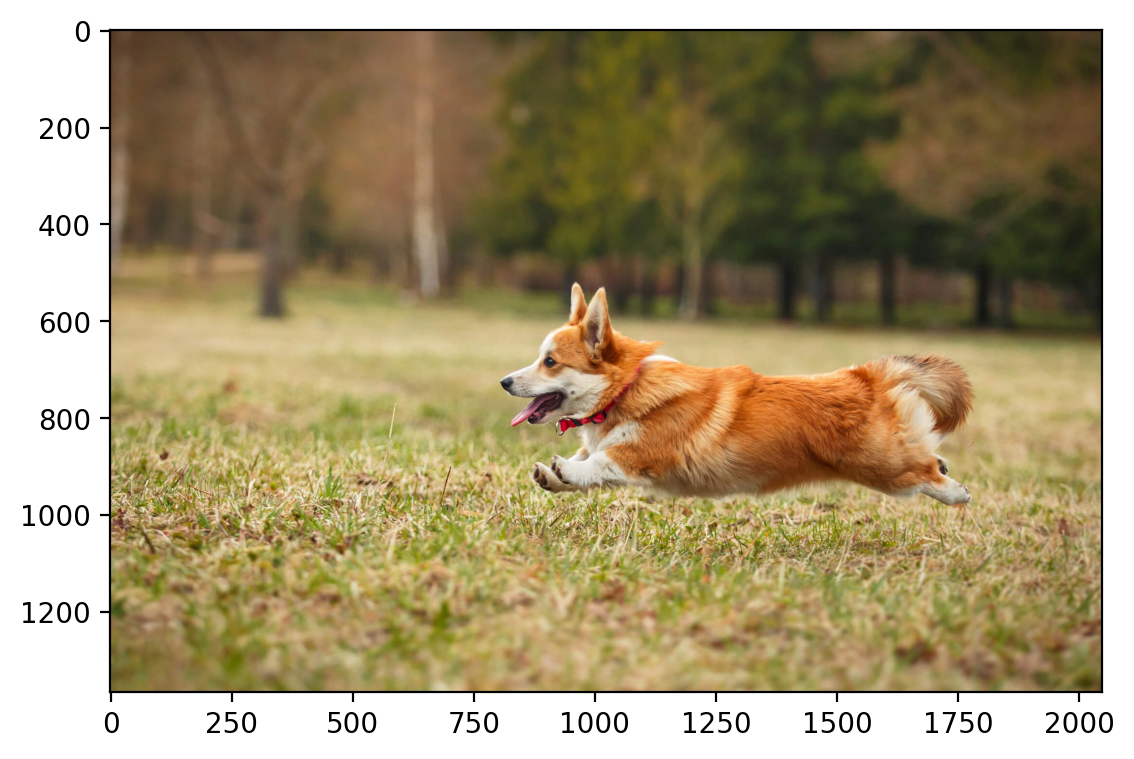

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)

(3, 1365, 2048)


In [ ]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 100, 100)
crop.shape

torch.Size([3, 100, 100])

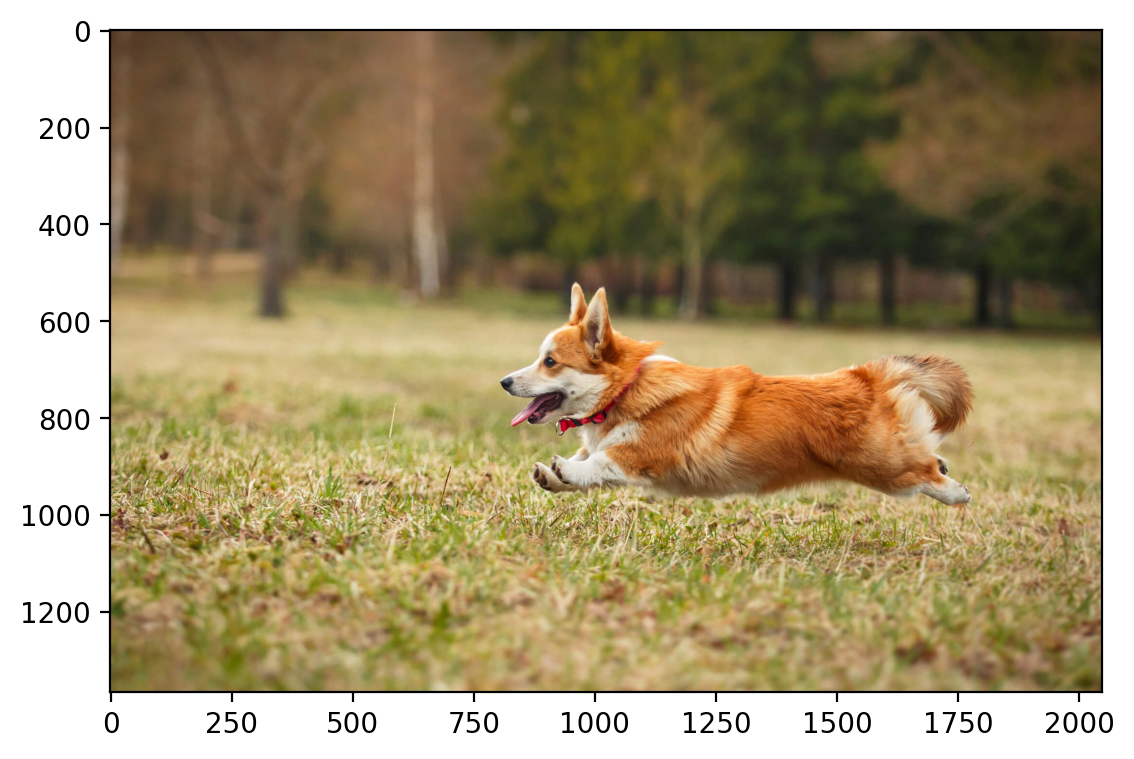

In [ ]:
crop = crop.to(device)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [ ]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 100 100


In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape
print(dog_X)

tensor([[ 0.,  0.],
        [ 0.,  1.],
        [ 0.,  2.],
        ...,
        [99., 97.],
        [99., 98.],
        [99., 99.]])


In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
print(dog_X_scaled.shape)


torch.Size([10000, 2])


In [ ]:
num_features=500
sigma=0.024
scale=2

In [ ]:
from sklearn.kernel_approximation import RBFSampler
rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
def create_rff_features(X, num_features, sigma):
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
X_rff = create_rff_features(dog_X_scaled, num_features, sigma)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.008, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.511976
Epoch 100 loss: 0.018201
Epoch 200 loss: 0.004802
Epoch 300 loss: 0.004414
Epoch 400 loss: 0.004334
Epoch 500 loss: 0.004316
Epoch 600 loss: 0.004311
Epoch 700 loss: 0.004307
Epoch 800 loss: 0.004304
Epoch 900 loss: 0.004302
Epoch 1000 loss: 0.004299
Epoch 1100 loss: 0.004296
Epoch 1200 loss: 0.004294
Epoch 1300 loss: 0.004291
Epoch 1400 loss: 0.004289
Epoch 1500 loss: 0.004286
Epoch 1600 loss: 0.004283
Epoch 1700 loss: 0.004280
Epoch 1800 loss: 0.004278
Epoch 1900 loss: 0.004275
Epoch 2000 loss: 0.004272
Epoch 2100 loss: 0.004269
Epoch 2200 loss: 0.004265
Epoch 2300 loss: 0.004262
Epoch 2400 loss: 0.004259


0.0042554340325295925

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_reconstructed_and_original_image(original_img, net, X, scale, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    """
    num_channels, height, width = original_img.shape
    scaled_height = int(height * scale)
    scaled_width = int(width * scale)

    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(scaled_height, scaled_width, num_channels)
    print(outputs.shape)
    fig = plt.figure(figsize=(8, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")



    fig.suptitle(title, y=0.9)
    plt.tight_layout()
# Example usage
# plot_reconstructed_and_original_image(original_img, net, X, scale)


In [ ]:
def create_coordinate_map(img, scale=2):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    height=scale*height
    width=scale*width

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
   # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    return X

In [ ]:
scale=2
dog_X_new=create_coordinate_map(crop, scale)
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X_new.cpu())

# Scale the X coordinates
dog_X_new = scaler_X.transform(dog_X_new.cpu())

# Move the scaled X coordinates to the GPU
dog_X_new = torch.tensor(dog_X_new).to(device)

# Set to dtype float32
dog_X_new = dog_X_new.float()
print(dog_X_new.shape)

torch.Size([40000, 2])


In [ ]:
X_scaled_rff = create_rff_features(dog_X_new, 400, sigma)
print(X_scaled_rff.shape)

torch.Size([40000, 500])


torch.Size([200, 200, 3])


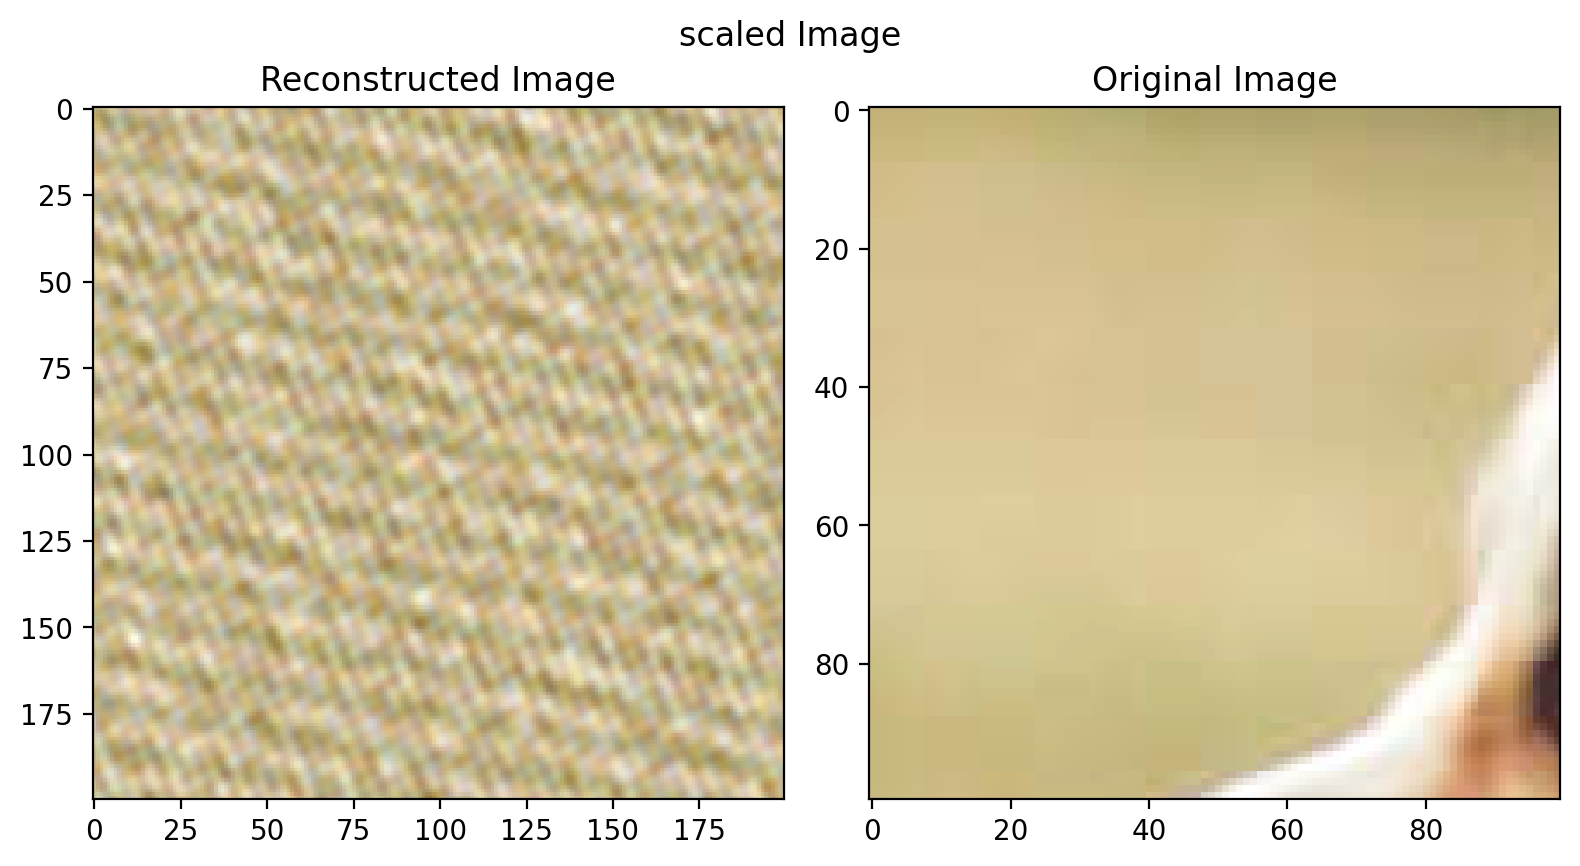

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_scaled_rff,scale, title="scaled Image")